# Ануфриев Н.В.
# Diamond price prediction

Цель - наилучшим способом используя линейные регрессии предсказать цену брильянта.

- price: цена в usd
- carat: вeс в каратах
- cut: качество огранки (Fair, Good, Very Good, Premium, Ideal)
- color: цветность брильянта (степень "желтезны"), от J (плохая) до D (наилучшая) 
- clarity: чистота брильянта (I1 (плохая), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (наилучшая)) 
- x: длинна в мм
- y: ширина в мм
- z: глубина в мм
- depth: общий процент глубины = z / mean(x, y) = 2 * z / (x + y)
- table: ширина вершины ромба относительно самого широкого места

### 1. Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import Lasso

### 2. Загружаем датасет

In [2]:
train_df = pd.read_csv('train.csv', sep=',')
train_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.55,Ideal,I,SI1,61.7,55.0,1134,5.29,5.31,3.27
1,0.94,Premium,E,SI1,62.4,56.0,4580,6.27,6.24,3.90
2,0.33,Premium,E,SI2,60.0,59.0,594,4.49,4.47,2.69
3,0.31,Ideal,D,VS2,59.4,56.0,879,4.45,4.40,2.63
4,2.01,Very Good,H,SI1,62.8,59.0,17759,7.99,8.04,5.03


In [3]:
# Смотрим размер тренировочного датасета

train_df.shape

(40455, 10)

In [4]:
# Смотрим info нашего датасета

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   price    40455 non-null  int64  
 7   x        40455 non-null  float64
 8   y        40455 non-null  float64
 9   z        40455 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB


In [5]:
# Проверяем на ненулевые значения

train_df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [6]:
train_df.loc[(train_df.x == 0), 'x'] = None
train_df.loc[(train_df.y == 0), 'y'] = None
train_df.loc[(train_df.z == 0), 'z'] = None
train_df.isnull().sum()

carat       0
cut         0
color       0
clarity     0
depth       0
table       0
price       0
x           8
y           7
z          14
dtype: int64

In [7]:
train_df.shape

(40455, 10)

In [8]:
train_df = train_df.dropna()
train_df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [9]:
train_df.shape

(40441, 10)

In [10]:
# Смотрим уникальные значения в стриговых столбцах

print('Уникальные значения столбца cut: ', train_df['cut'].unique())
print('Уникальные значения столбца clarity: ', train_df['clarity'].unique())
print('Уникальные значения столбца color: ', train_df['color'].unique())

Уникальные значения столбца cut:  ['Ideal' 'Premium' 'Very Good' 'Good' 'Fair']
Уникальные значения столбца clarity:  ['SI1' 'SI2' 'VS2' 'VS1' 'VVS1' 'VVS2' 'IF' 'I1']
Уникальные значения столбца color:  ['I' 'E' 'D' 'H' 'F' 'G' 'J']


In [11]:
encoder = LabelEncoder()

train_df["cut"] = encoder.fit_transform(train_df['cut'])
encode_cut = {index : label for index, label in enumerate(encoder.classes_)}
train_df["color"] = encoder.fit_transform(train_df['color'])
encode_color = {index : label for index, label in enumerate(encoder.classes_)}
train_df['clarity'] = encoder.fit_transform(train_df['clarity'])
encode_clarity = {index : label for index, label in enumerate(encoder.classes_)}

print('Перекодированный словарь cut: ', encode_cut)
print('Перекодированный словарь color: ', encode_color)
print('Перекодированный словарь clarity: ', encode_clarity)

Перекодированный словарь cut:  {0: 'Fair', 1: 'Good', 2: 'Ideal', 3: 'Premium', 4: 'Very Good'}
Перекодированный словарь color:  {0: 'D', 1: 'E', 2: 'F', 3: 'G', 4: 'H', 5: 'I', 6: 'J'}
Перекодированный словарь clarity:  {0: 'I1', 1: 'IF', 2: 'SI1', 3: 'SI2', 4: 'VS1', 5: 'VS2', 6: 'VVS1', 7: 'VVS2'}


In [12]:
train_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.55,2,5,2,61.7,55.0,1134,5.29,5.31,3.27
1,0.94,3,1,2,62.4,56.0,4580,6.27,6.24,3.90
2,0.33,3,1,3,60.0,59.0,594,4.49,4.47,2.69
3,0.31,2,0,5,59.4,56.0,879,4.45,4.40,2.63
4,2.01,4,4,2,62.8,59.0,17759,7.99,8.04,5.03


In [13]:
# Выносим из тренировочного датасета столбец с price

y = train_df['price']
X = train_df.drop('price', axis=1)

X.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.55,2,5,2,61.7,55.0,5.29,5.31,3.27
1,0.94,3,1,2,62.4,56.0,6.27,6.24,3.90
2,0.33,3,1,3,60.0,59.0,4.49,4.47,2.69
3,0.31,2,0,5,59.4,56.0,4.45,4.40,2.63
4,2.01,4,4,2,62.8,59.0,7.99,8.04,5.03


<AxesSubplot:>

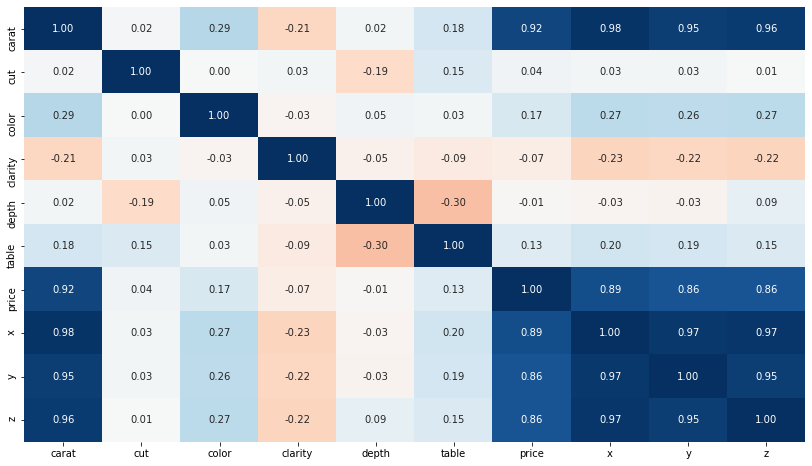

In [14]:
fig, ax = plt.subplots(figsize=(14,8))
corr = train_df.corr()
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, fmt='.2f', cbar=False)

In [15]:
# Разделяем датасет на трейн и тест

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
std_model = LinearRegression()
ridge_model = Ridge(alpha=1)
lasso_model = Lasso(alpha=1)

std_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)

Lasso(alpha=1)

In [17]:
print(f"Without regression: {std_model.score(X_train, y_train)}")
print(f"Without regression test: {std_model.score(X_test, y_test)}")

print(f"\nRidge Regression: {ridge_model.score(X_train, y_train)}")
print(f"Ridge Regression test: {ridge_model.score(X_test, y_test)}")

print(f"\nLasso regression: {lasso_model.score(X_train, y_train)}")
print(f"Lasso regression test: {lasso_model.score(X_test, y_test)}")

Without regression: 0.8848262592926828
Without regression test: 0.8854914482198818

Ridge Regression: 0.8848253755757771
Ridge Regression test: 0.885497074239709

Lasso regression: 0.8848086025438465
Lasso regression test: 0.8854861582182737


In [18]:
std_model_p = make_pipeline(MinMaxScaler(), LinearRegression())
std_model_p.fit(X_train, y_train)

ridge_model_p = make_pipeline(MinMaxScaler(), PolynomialFeatures(degree=2, include_bias=False), Ridge())
ridge_model_p.fit(X_train, y_train)

lasso_model_p = make_pipeline(MinMaxScaler(), PolynomialFeatures(degree=2, include_bias=False), Lasso())
lasso_model_p.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('lasso', Lasso())])

In [19]:
print(f"Without regression: {std_model_p.score(X_train, y_train)}")
print(f"Without regression: {std_model_p.score(X_test, y_test)}")

print(f"\nRidge Regression : {ridge_model_p.score(X_train, y_train)}")
print(f"Ridge Regression : {ridge_model_p.score(X_test, y_test)}")

print(f"\nLasso regression: {lasso_model_p.score(X_train, y_train)}")
print(f"Lasso regression: {lasso_model_p.score(X_test, y_test)}")
print("Количество использованных признаков: {}".format(np.sum(lasso_model_p.named_steps['lasso'].coef_ != 0)))

Without regression: 0.8848262592926828
Without regression: 0.8854914482198818

Ridge Regression : 0.9263063966881754
Ridge Regression : 0.9251732275324236

Lasso regression: 0.9230731455460802
Lasso regression: 0.9220828041833764
Количество использованных признаков: 17


In [24]:
pipeline_final = make_pipeline(MinMaxScaler(), PolynomialFeatures(degree=2, include_bias=False), Lasso())
pipeline_final.fit(X_train, y_train)

df_test = pd.read_csv("test.csv")

df_test["cut"] = encoder.fit_transform(df_test['cut'])
encode_cut = {index : label for index, label in enumerate(encoder.classes_)}
df_test["color"] = encoder.fit_transform(df_test['color'])
encode_color = {index : label for index, label in enumerate(encoder.classes_)}
df_test['clarity'] = encoder.fit_transform(df_test['clarity'])
encode_clarity = {index : label for index, label in enumerate(encoder.classes_)}

y_predict = pipeline_final.predict(df_test)